All methods require user authorization. Register the app at your [dashboard](https://developer.spotify.com/dashboard) to get the credentials. When creating the app, select "Web API" and set `http://localhost:8888/callback` as "Redirect URI" (as suggested in a [video](https://youtu.be/3RGm4jALukM) in the Spotipy [documentation](https://spotipy.readthedocs.io)). Then, before running the notebook, set the environment variables of the credentials (client ID and client secret) in your terminal:

* `export SPOTIPY_CLIENT_ID=`...
* `export SPOTIPY_CLIENT_SECRET=`...

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

Tracks are obtained from playlists of different genres. You can get the ID of a playlist from its URL. Some of the genres are:

* [pop](https://open.spotify.com/genre/0JQ5DAqbMKFEC4WFtoNRpw)
* [blues](https://open.spotify.com/genre/0JQ5DAqbMKFQiK2EHwyjcU)
* [country](https://open.spotify.com/genre/0JQ5DAqbMKFKLfwjuJMoNC)
* [rock](https://open.spotify.com/genre/0JQ5DAqbMKFDXXwE9BDJAr)
* [classical](https://open.spotify.com/genre/0JQ5DAqbMKFPrEiAOxgac3)
* [reggae](https://open.spotify.com/genre/0JQ5DAqbMKFJKoGyUMo2hE)
* [disco](https://open.spotify.com/genre/0JQ5DAqbMKFwT0m6BbKvGP) (it was under Dance/Electronic)
* [hiphop](https://open.spotify.com/genre/0JQ5DAqbMKFQ00XGBls6ym)
* [jazz](https://open.spotify.com/genre/0JQ5DAqbMKFAJ5xb0fwo9m)
* [metal](https://open.spotify.com/genre/0JQ5DAqbMKFDkd668ypn6O)

You can search for more genres in [Spotify](https://open.spotify.com/search)

In [2]:
playlists = { #TODO re-choose them with some criteria
    'pop': ['37i9dQZF1DX6wfQutivYYr', '37i9dQZF1DX01NP73ErE8b'],
    'blues': ['37i9dQZF1DXd9rSDyQguIk', '37i9dQZF1DXcu3QLJudo4X'],
    'country': ['37i9dQZF1DWZBCPUIUs2iR', '37i9dQZF1DWTkxQvqMy4WW'],
    'rock': ['37i9dQZF1DWViUlcvfltyZ', '37i9dQZF1DWW9tK1GiTdMf'],
    'classical': ['37i9dQZF1DWWEJlAGA9gs0', '37i9dQZF1DWV0gynK7G6pD'],
    'reggae': ['37i9dQZF1DWSiyIBdVQrkk', '37i9dQZF1DXbSbnqxMTGx9'],
    'disco': ['37i9dQZF1DX3jWba5xiDhV', '37i9dQZF1DX1MUPbVKMgJE'],
    'hiphop': ['37i9dQZF1DX14EWeH2Pwf3', '37i9dQZF1DWYQKKZPHGppf'],
    'jazz': ['37i9dQZF1DX30D074EWuy7', '37i9dQZF1DX55mNLGdHona'],
    'metal': ['37i9dQZF1DWWOaP4H0w5b0', '37i9dQZF1DXe6bgV3TmZOL']}

In [3]:
from contextlib import suppress

#get features
features_ = []
for genre, playlists_ in playlists.items():
    for playlist in playlists_:
        tracks = []

        #get track ids, preview urls and genres
        for item in spotify.playlist_tracks(playlist)['items']:
            with suppress(TypeError): #skips missing tracks
                tracks.append({
                    'id': item['track']['id'],
                    'preview_url': item['track']['preview_url'],
                    'genre': genre})

        #get danceability values
        ids = [track['id'] for track in tracks]
        for track, features in zip(tracks, spotify.audio_features(ids)):
            with suppress(TypeError, AssertionError): #skips missing and wrong features
                assert track['id'] == features['id']
                track['danceability'] = features['danceability']

        features_.extend(tracks)
        print('.', end='')
len(features_)

....................

1492

In [4]:
import os
import pandas as pd

#create data directory
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

#save features
features_path = os.path.join(data_dir, 'features.csv')
features = pd.DataFrame(features_).dropna().drop_duplicates('id', ignore_index=True)
features.sample(frac=0.01, random_state=42).to_csv(features_path, index=False) #TODO frac=1
features = pd.read_csv(features_path)
features.tail(2)

,id,preview_url,genre,danceability
946,49v38DJoDmsKR2hLuuX035,https://p.scdn.co/mp3-preview/1a69a90925ea1101...,reggae,0.593
947,7a6dNBkRHict66PWnCqbqT,https://p.scdn.co/mp3-preview/9ea41a3f323ec318...,blues,0.351


In [5]:
from urllib.request import urlretrieve
from concurrent.futures import ThreadPoolExecutor

#create audio directory
audio_dir = os.path.join(data_dir, 'audio')
os.makedirs(audio_dir, exist_ok=True)

def download(row):
    audio_path = os.path.join(audio_dir, f"{row['id']}.mp3")
    urlretrieve(row['preview_url'], audio_path)
    if row.name % 10 == 0:
        print('.', end='')

#download previews
with ThreadPoolExecutor() as executor:
    for result in executor.map(download, features.iloc):
        pass #raises errors if any

...............................................................................................

In [6]:
from joblib import delayed, Parallel #ProcessPoolExecutor not working with librosa
from utils.preprocessing import audio_to_spec
import importlib; from utils import preprocessing; importlib.reload(preprocessing) #for debugging purposes

#create spectrogram directory
spec_dir = os.path.join(data_dir, 'spec')
os.makedirs(spec_dir, exist_ok=True)

@delayed
def get_spec(id):
    audio_path = os.path.join(audio_dir, f"{id}.mp3")
    spec_path = os.path.join(spec_dir, f"{id}.png")
    audio_to_spec(audio_path).save(spec_path)

#compute and save spectrograms
with Parallel(n_jobs=-1, verbose=2) as parallel:
    parallel(get_spec(id) for id in features['id'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 948 out of 948 | elapsed:  2.4min finished


,id,preview_url,genre,danceability
947,7a6dNBkRHict66PWnCqbqT,https://p.scdn.co/mp3-preview/9ea41a3f323ec318...,blues,0.351


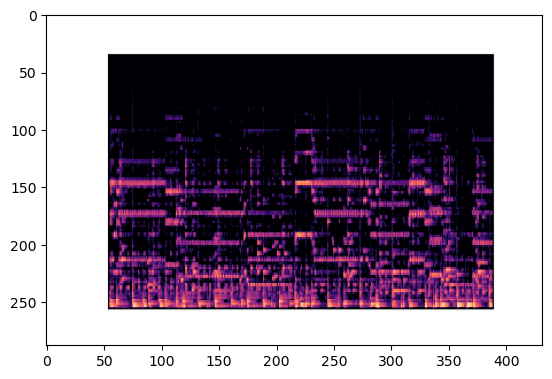

In [7]:
from utils.dataset import SpectrogramsDataset
import matplotlib.pyplot as plt
from utils import dataset; importlib.reload(dataset) #for debugging purposes

i = -1

#test genre dataset
dataset = SpectrogramsDataset(spec_dir, features_path, target='genre')
spec, label = dataset[i]
assert dataset.classes[label] == features.iloc[i]['genre']

#test danceability dataset
dataset = SpectrogramsDataset(spec_dir, features_path, target='danceability')
spec, label = dataset[i]
assert label == features.iloc[i]['danceability']

plt.imshow(spec)
features.iloc[[i]]